# Exploratory Data Analysis

This notebook loads and explores the three CSVs in `data/` for basic structure, missingness, distributions, and quick cross-tabs.

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate
from collections import defaultdict
import json
import random


In [34]:
data_dir = Path("..") / "data"
players_path = data_dir / "players.csv"
player_games_path = data_dir / "player_games.csv"
vgsales_path = data_dir / "vgsales.csv"

players = pd.read_csv(players_path)
player_games = pd.read_csv(player_games_path)
vgsales = pd.read_csv(vgsales_path)

players.shape, player_games.shape, vgsales.shape


((11959, 6), (59795, 9), (16598, 11))

## Players
- This data set was synthetically generated.

In [35]:
# Looking at the players dataset.
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11959 entries, 0 to 11958
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   11959 non-null  int64  
 1   age_group                 11959 non-null  object 
 2   session_count_per_week    11959 non-null  int64  
 3   avg_session_length_hours  11959 non-null  float64
 4   primary_genre             11959 non-null  object 
 5   preferred_platform        11959 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 560.7+ KB


In [36]:
players.describe()

,user_id,session_count_per_week,avg_session_length_hours
count,11959.000000,11959.000000,11959.000000
mean,5980.000000,5.649218,2.014694
std,3452.410269,3.296081,0.691597
min,1.000000,2.000000,0.500000
25%,2990.500000,3.000000,1.540000
50%,5980.000000,5.000000,2.010000
75%,8969.500000,7.000000,2.480000
max,11959.000000,14.000000,4.610000


In [37]:
# How many players are in each age group?
players['age_group'].value_counts()

age_group
Teen     5924
Adult    3646
Kids     2389
Name: count, dtype: int64

In [38]:
# Based off of age group, what are some statistics for number of sessions per week and average session length?
players.groupby('age_group')[['session_count_per_week', 'avg_session_length_hours']].agg(['mean','median','min','max'])

session_count_per_week                avg_session_length_hours  \
                            mean median min max                     mean   
age_group                                                                  
Adult                   5.702414    5.0   2  14                 2.026676   
Kids                    5.687317    5.0   2  14                 2.011875   
Teen                    5.601114    5.0   2  14                 2.008455   

                             
          median  min   max  
age_group                    
Adult       2.03  0.5  4.32  
Kids        2.01  0.5  4.60  
Teen        2.00  0.5  4.61

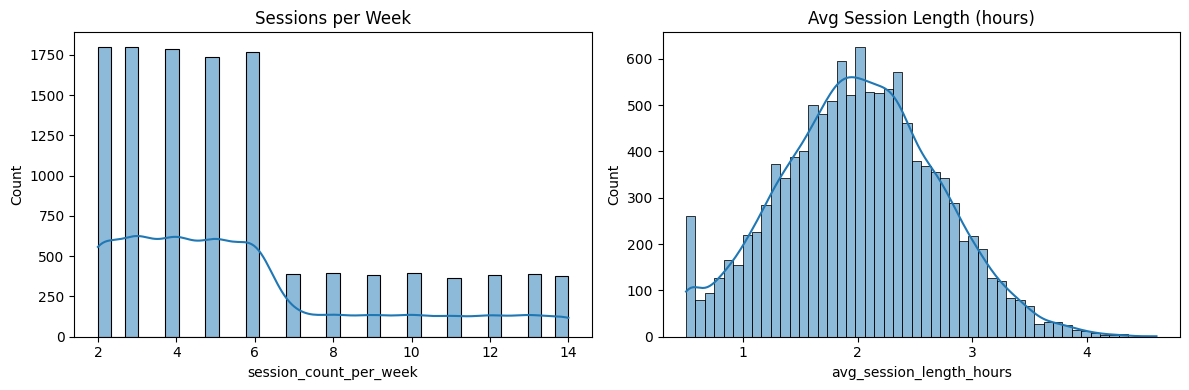

In [39]:
# Looking at the distribution of session counts and average session lengths.
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(players['session_count_per_week'], kde=True, ax=axes[0])
axes[0].set_title('Sessions per Week')
sns.histplot(players['avg_session_length_hours'], kde=True, ax=axes[1])
axes[1].set_title('Avg Session Length (hours)')
plt.tight_layout()

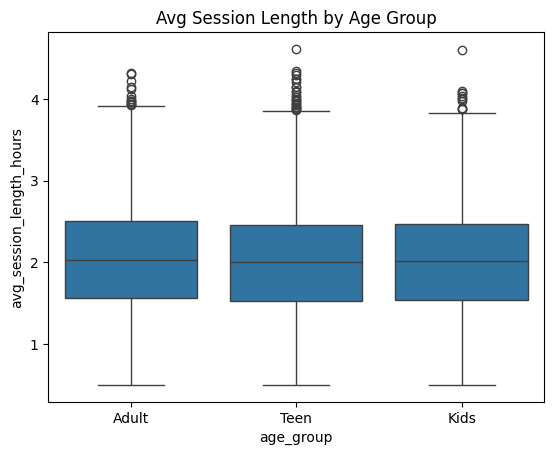

In [40]:
# Visualizing session length by age group
sns.boxplot(x='age_group', y='avg_session_length_hours', data=players)
plt.title('Avg Session Length by Age Group')
plt.show()

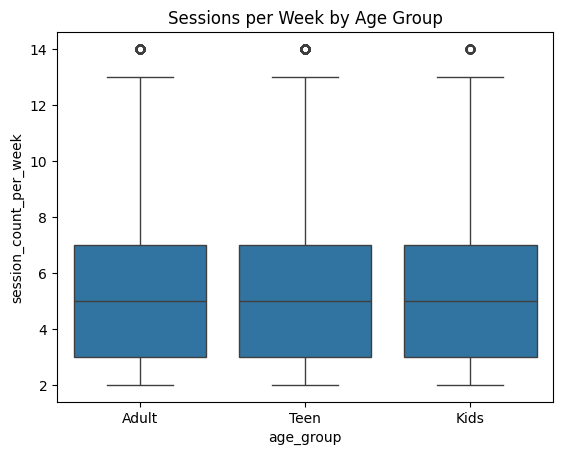

In [41]:
# Visualizing session count per week by age group
# The player_gen tool didn't randomize this column well, but a real-world dataset would probably have more variation.
sns.boxplot(x='age_group', y='session_count_per_week', data=players)
plt.title('Sessions per Week by Age Group')
plt.show()

## Player Games
- This data set was synthetically generated, but I still want to explore it.

In [42]:
player_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59795 entries, 0 to 59794
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         59795 non-null  int64  
 1   game_title      59795 non-null  object 
 2   platform        59795 non-null  object 
 3   genre           59795 non-null  object 
 4   release_year    58812 non-null  float64
 5   publisher       59584 non-null  object 
 6   global_sales    59795 non-null  float64
 7   playtime_hours  59795 non-null  float64
 8   player_rating   59795 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 4.1+ MB


In [43]:
player_games.describe()

,user_id,release_year,global_sales,playtime_hours,player_rating
count,59795.00000,58812.000000,59795.000000,59795.000000,59795.000000
mean,5980.00000,2006.424641,0.537874,6.042779,2.949367
std,3452.29479,5.806611,1.614241,4.456615,0.753637
min,1.00000,1980.000000,0.010000,0.500000,1.000000
25%,2990.00000,2003.000000,0.060000,3.458654,2.430000
50%,5980.00000,2007.000000,0.170000,5.277986,2.930000
75%,8970.00000,2010.000000,0.470000,7.266400,3.450000
max,11959.00000,2020.000000,82.740000,40.703874,5.000000


In [44]:
# How many unique platforms, game titles, genres, and release years are there?
player_games[['platform', 'game_title', 'genre','release_year']].nunique()


platform           31
game_title      11492
genre              12
release_year       39
dtype: int64

In [45]:
# How many games are there per platform?
player_games['platform'].value_counts()

# Definitely skewed towards more modern gaming in this dataset.
# Especially DS titles - that's mostly Nintendo handheld games.

platform
DS      7891
PS2     7841
PS3     4790
Wii     4741
X360    4549
PSP     4403
PS      4286
PC      3416
XB      2969
GBA     2966
GC      1992
3DS     1808
PSV     1513
PS4     1206
N64     1142
SNES     846
XOne     756
SAT      618
WiiU     506
2600     466
GB       354
NES      353
DC       180
GEN       94
NG        44
SCD       21
WS        20
3DO       10
TG16       7
PCFX       4
GG         3
Name: count, dtype: int64

In [46]:
# How mnay games are there per genre?
player_games['genre'].value_counts()

# Most games are Action or Sports.
# There are quite a lot of "Misc" games too - not sure what those are.

genre
Action          11970
Sports           8490
Misc             6290
Role-Playing     5410
Shooter          4675
Adventure        4675
Racing           4530
Platform         3180
Simulation       3055
Fighting         2980
Strategy         2425
Puzzle           2115
Name: count, dtype: int64

In [47]:
# Looking at examples of games of the "Misc" genre
player_games[player_games['genre'] == 'Misc'].head(n=100)

,user_id,game_title,platform,genre,release_year,publisher,global_sales,playtime_hours,player_rating
16985,3398,Wii Play,Wii,Misc,2006.0,Nintendo,29.02,5.869957,1.66
16986,3398,Jampack Spring 2004 (RP-T),PS2,Misc,2003.0,Sony Computer Entertainment,0.41,6.299864,2.18
16987,3398,Codename: Kids Next Door: Game Boy Advance Vid...,GBA,Misc,2004.0,NaN,0.17,4.623501,3.43
16988,3398,Rock Band Track Pack: Classic Rock,X360,Misc,2009.0,MTV Games,0.07,6.101976,1.45
16989,3398,You Don't Know Jack,PC,Misc,1995.0,Vivendi Games,0.02,6.753385,2.00
...,...,...,...,...,...,...,...,...,...
17080,3417,Mario Party DS,DS,Misc,2007.0,Nintendo,9.02,13.767694,3.11
17081,3417,SpongeBob SquigglePants,Wii,Misc,2011.0,THQ,0.41,4.341520,2.73
17082,3417,Bomberman Land,Wii,Misc,2007.0,Rising Star Games,0.17,7.013869,2.44
17083,3417,My Dress-Up,DS,Misc,2008.0,Oxygen Interactive,0.07,20.540851,4.09


In [48]:
# What genre do these games have from the sales dataset?
vgsales[vgsales['Name'].isin(player_games[player_games['genre'] == 'Misc']['game_title'].unique())][['Name','Genre']].drop_duplicates().head(n=100)

# Yep, seems like the "Misc" genre in player_games corresponds to those titles in the sales dataset too.
# It's interesting, because I see "Minecraft" here, which is usually classified as Sandbox or Survival.
# I guess "Misc" is just a catch-all for games that don't fit neatly into other categories defined in the data set for now.
# For future projects, I'd probably try to refine these genre labels a bit more.

,Name,Genre
7,Wii Play,Misc
15,Kinect Adventures!,Misc
19,Brain Age: Train Your Brain in Minutes a Day,Misc
60,Just Dance 3,Misc
68,Just Dance 2,Misc
...,...,...
1324,4 Nin uchi Mahjong,Misc
1327,Namco Museum 64,Misc
1331,My Word Coach,Misc
1332,Hello Kitty Party,Misc


In [49]:
# How many games are there for each combination of platform and genre?
player_games[['platform','genre']].value_counts()

platform  genre    
PS2       Sports       1451
DS        Misc         1442
PS3       Action       1355
PS2       Action       1285
DS        Action       1242
                       ... 
GEN       Racing          3
NG        Sports          3
TG16      Shooter         3
GB        Shooter         3
3DO       Adventure       3
Name: count, Length: 293, dtype: int64

In [50]:
# Which platforms have the highest average playtime hours?
player_games.groupby('platform')['playtime_hours'].mean().sort_values(ascending=False)

platform
DS      7.142651
PS2     7.140786
PS3     6.039137
Wii     6.033498
X360    5.997810
PCFX    5.865911
PS      5.850155
GG      5.843280
PSP     5.814726
PC      5.671329
XB      5.660967
GEN     5.485984
GBA     5.337448
GC      5.295808
SAT     5.219366
3DS     5.205030
DC      5.135836
GB      5.128663
WiiU    5.127961
PSV     5.107586
SNES    5.101761
NG      5.098376
NES     5.089675
TG16    5.087840
XOne    5.063003
PS4     5.059669
N64     5.058548
2600    5.043160
SCD     4.920850
WS      4.576416
3DO     4.169893
Name: playtime_hours, dtype: float64

In [51]:
# Which platform has the best player ratings on average?
player_games.groupby('platform')['player_rating'].mean().sort_values(ascending=False)

platform
DS      3.063155
PS2     3.049054
PS3     2.965046
DC      2.940500
X360    2.935645
PSP     2.932819
Wii     2.928920
PC      2.919836
NG      2.918636
PS      2.916864
XOne    2.899193
SAT     2.894806
XB      2.893378
GBA     2.893014
GB      2.892825
PSV     2.891514
WS      2.891500
SCD     2.889524
2600    2.884356
SNES    2.881785
PS4     2.875763
WiiU    2.873458
N64     2.872916
GC      2.859247
3DS     2.836289
NES     2.814476
TG16    2.765714
GEN     2.747872
GG      2.573333
3DO     2.408000
PCFX    1.942500
Name: player_rating, dtype: float64

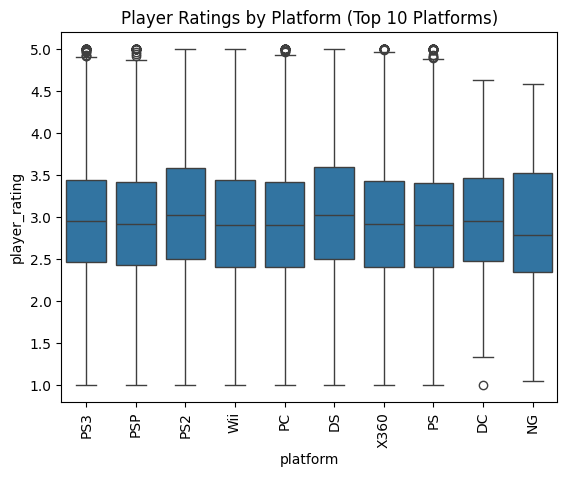

In [52]:
# Looking at a box plot of platform and player rating
# I'll sort by the top 10 platforms by average player rating for better visualization.
top_platforms = player_games.groupby('platform')['player_rating'].mean().sort_values(ascending=False).head(10).index
sns.boxplot(x='platform', y='player_rating', data=player_games[player_games['platform'].isin(top_platforms)])
plt.title('Player Ratings by Platform (Top 10 Platforms)')
plt.xticks(rotation=90)
plt.show()

In [53]:
# Which genre has the highest average player rating?
player_games.groupby('genre')['player_rating'].mean().sort_values(ascending=False)

genre
Puzzle          2.989660
Simulation      2.971018
Misc            2.967781
Adventure       2.960518
Strategy        2.958082
Racing          2.957172
Role-Playing    2.952353
Fighting        2.944638
Shooter         2.942135
Action          2.936865
Sports          2.935706
Platform        2.924698
Name: player_rating, dtype: float64

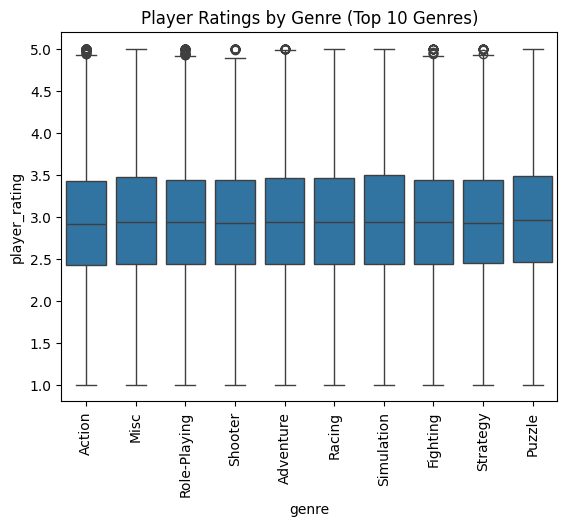

In [54]:
# Looking at a box plot of genre and player rating
# Similar to the last boxplot, I'll grab the top 10 genres here
top_genres = player_games.groupby('genre')['player_rating'].mean().sort_values(ascending=False).head(10).index
sns.boxplot(x='genre', y='player_rating', data=player_games[player_games['genre'].isin(top_genres)])
plt.title('Player Ratings by Genre (Top 10 Genres)')
plt.xticks(rotation=90)
plt.show()

## Video Game Sales

In [55]:
vgsales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [56]:
# Do we have any missing values in the sales dataset?
vgsales.isna().sum()

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

In [57]:
vgsales.describe(include='all')

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16598.000000,16598,16598,16327.000000,16598,16540,16598.000000,16598.000000,16598.000000,16598.000000,16598.000000
unique,NaN,11493,31,NaN,12,578,NaN,NaN,NaN,NaN,NaN
top,NaN,Need for Speed: Most Wanted,DS,NaN,Action,Electronic Arts,NaN,NaN,NaN,NaN,NaN
freq,NaN,12,2163,NaN,3316,1351,NaN,NaN,NaN,NaN,NaN
mean,8300.605254,NaN,NaN,2006.406443,NaN,NaN,0.264667,0.146652,0.077782,0.048063,0.537441
std,4791.853933,NaN,NaN,5.828981,NaN,NaN,0.816683,0.505351,0.309291,0.188588,1.555028
min,1.000000,NaN,NaN,1980.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.010000
25%,4151.250000,NaN,NaN,2003.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.060000
50%,8300.500000,NaN,NaN,2007.000000,NaN,NaN,0.080000,0.020000,0.000000,0.010000,0.170000
75%,12449.750000,NaN,NaN,2010.000000,NaN,NaN,0.240000,0.110000,0.040000,0.040000,0.470000


In [58]:
# How many sales per platform?
vgsales['Platform'].value_counts()

Platform
DS      2163
PS2     2161
PS3     1329
Wii     1325
X360    1265
PSP     1213
PS      1196
PC       960
XB       824
GBA      822
GC       556
3DS      509
PSV      413
PS4      336
N64      319
SNES     239
XOne     213
SAT      173
WiiU     143
2600     133
NES       98
GB        98
DC        52
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: count, dtype: int64

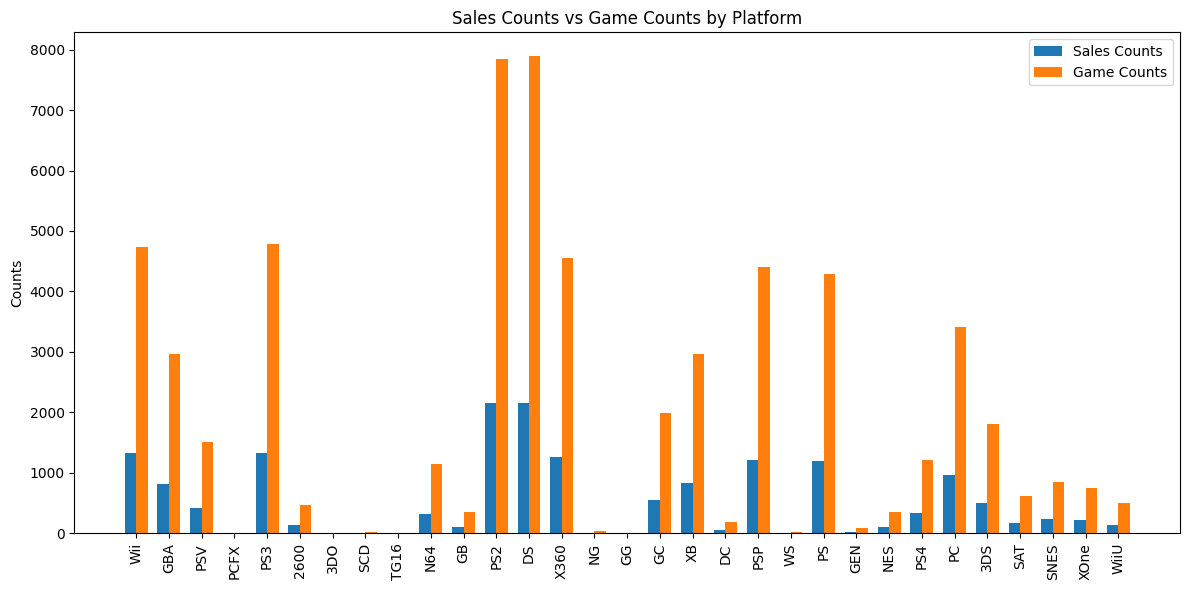

In [59]:
# Do the sales per platform align with the number of games played per platform in the player_games dataset?
platform_sales_counts = vgsales['Platform'].value_counts()
platform_game_counts = player_games['platform'].value_counts()

# Visualizing the two distributions side by side
platforms = set(platform_sales_counts.index).union(set(platform_game_counts.index))
sales_counts = [platform_sales_counts.get(platform, 0) for platform in platforms]
game_counts = [platform_game_counts.get(platform, 0) for platform in platforms]
x = np.arange(len(platforms))
width = 0.35
fig, ax = plt.subplots(figsize=(12,6))
bars1 = ax.bar(x - width/2, sales_counts, width, label='Sales Counts')
bars2 = ax.bar(x + width/2, game_counts, width, label='Game Counts')
ax.set_xticks(x)
ax.set_xticklabels(platforms, rotation=90)
ax.set_ylabel('Counts')
ax.set_title('Sales Counts vs Game Counts by Platform')
ax.legend()
plt.tight_layout()
plt.show()

# Yep, I'd say there is a trend.
# Games that had more sales have more play records in the player_games dataset.

In [60]:
# How many sales per genre?
vgsales['Genre'].value_counts()

Genre
Action          3316
Sports          2346
Misc            1739
Role-Playing    1488
Shooter         1310
Adventure       1286
Racing          1249
Platform         886
Simulation       867
Fighting         848
Strategy         681
Puzzle           582
Name: count, dtype: int64

## Summary of EDA and Preprocessing Work
- Loaded three datasets from `data/` (`players`, `player_games`, `vgsales`).
- Explored each dataset: `info()`, `describe()`, value counts, grouped stats and several plots.


## Part 1: Recommendation System with Surprise
- Answering part 1 of the final project, which is to recommend games to players based on their past play history. For simplicity, I'll use collaborative filtering with the `Surprise` library using ratings derived from players.


In [61]:
# First, I need to filter down to a data frame with three columns for this model:
# UserID, Game Title, and user rating.
# The player_games csv has those three columns, so I'll go ahead and grab it.
model_df = pd.read_csv("../data/player_games.csv")
cols_to_keep = ['user_id', 'game_title', 'player_rating']

rating_df = model_df[cols_to_keep]

In [62]:
# Using surprise
reader = Reader(rating_scale=(1.0, 5.0))
data = Dataset.load_from_df(rating_df, reader)

algo = SVD()

# Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7756  0.7684  0.7688  0.7815  0.7757  0.7740  0.0049  
MAE (testset)     0.6186  0.6135  0.6134  0.6256  0.6175  0.6177  0.0045  
Fit time          0.23    0.24    0.24    0.24    0.25    0.24    0.01    
Test time         0.02    0.02    0.07    0.02    0.02    0.03    0.02    


{'test_rmse': array([0.77561042, 0.76841783, 0.7687912 , 0.78150812, 0.77565621]),
 'test_mae': array([0.6186215 , 0.61352798, 0.61336035, 0.62561748, 0.6175117 ]),
 'fit_time': (0.2341620922088623,
  0.24496197700500488,
  0.23569416999816895,
  0.23739290237426758,
  0.2491130828857422),
 'test_time': (0.021291017532348633,
  0.019502878189086914,
  0.06631183624267578,
  0.01961803436279297,
  0.020987987518310547)}

In [63]:


def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
# Train the model on the full dataset
print("Training the model on the full dataset...")
trainset = data.build_full_trainset()
algo.fit(trainset)
print("Model trained.")

# Predict ratings for all pairs that are not in the training set.
print("Generating recommendations...")
testset = trainset.build_anti_testset()
predictions = algo.test(testset)
print("Recommendations generated.")

print("Getting the top 5 recommendations for each user...")
top_n = get_top_n(predictions,n=5)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(f"User {uid}:")
    for (iid, est) in user_ratings:
        print(f"  Game: {iid}, Estimated Rating: {est:0.2f}")
    print()


Training the model on the full dataset...
Model trained.
Generating recommendations...
Recommendations generated.
Getting the top 5 recommendations for each user...
Selected sample users: [8900, 7966, 11234, 3462, 1652, 251, 5261, 7181, 7910, 1762]


FileNotFoundError: [Errno 2] No such file or directory: 'data/sample_recommendations.json'

In [67]:
# Exporting a sample of recommendations to JSON
all_users = list(top_n.keys())
sample_users = random.sample(all_users, 10)

print(f"Selected sample users: {sample_users}")

sample_rows = []
for uid in sample_users:
    for (iid, est) in top_n[uid]:
        sample_rows.append({
            "user_id": uid,
            "game_id": iid,
            "est_rating": float(est)
        })

output_path = Path("../data/sample_recommendations.json")

with open(output_path, "w") as f:
    json.dump(sample_rows, f, indent=4)

print(f"Exported sample recommendations to {output_path.resolve()}")


Selected sample users: [3053, 9587, 9522, 9967, 11164, 4542, 10886, 1164, 10827, 5957]
Exported sample recommendations to /Users/zenful/School/INFO523/final-project-spencer-atchley-solo/data/sample_recommendations.json


## Part 2: Which factors influence a game's global sales performance?
Short, EDA-only pass with small steps and conversational notes.

### Game plan
- Clean the year field and sanity-check the sales columns.
- Look at when sales peaked and how skewed the distribution is.
- Compare medians by genre and platform (with a minimum title count to avoid tiny samples).
- See which publishers dominate totals.
- Peek at regional mix for the biggest hits.

In [ ]:
# Start with a clean copy and fix Year.
sales = vgsales.copy()
sales['Year'] = pd.to_numeric(sales['Year'], errors='coerce')
missing_year = sales['Year'].isna().sum()
sales_clean = sales.dropna(subset=['Year']).assign(Year=lambda df: df['Year'].astype(int))
print(f'Rows with missing Year dropped: {missing_year}')
sales_clean[['Global_Sales','NA_Sales','EU_Sales','JP_Sales','Other_Sales']].describe()


Rows with missing Year dropped: 271


,Global_Sales,NA_Sales,EU_Sales,JP_Sales,Other_Sales
count,16327.00,16327.00,16327.00,16327.00,16327.00
mean,0.54,0.27,0.15,0.08,0.05
std,1.57,0.82,0.51,0.31,0.19
min,0.01,0.00,0.00,0.00,0.00
25%,0.06,0.00,0.00,0.00,0.00
50%,0.17,0.08,0.02,0.00,0.01
75%,0.48,0.24,0.11,0.04,0.04
max,82.74,41.49,29.02,10.22,10.57


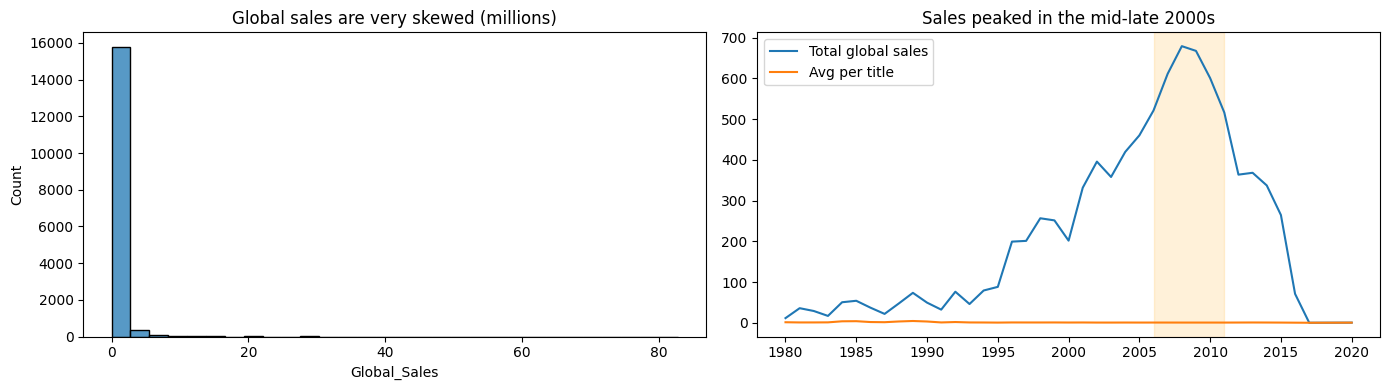

In [ ]:
# Let's peek at the sales distribution and how totals moved over time.
fig, axes = plt.subplots(1, 2, figsize=(14,4))
sns.histplot(sales_clean['Global_Sales'], bins=30, ax=axes[0])
axes[0].set_title('Global sales are very skewed (millions)')

yearly = sales_clean.groupby('Year')['Global_Sales'].agg(total='sum', mean='mean')
axes[1].plot(yearly.index, yearly['total'], label='Total global sales')
axes[1].plot(yearly.index, yearly['mean'], label='Avg per title')
axes[1].axvspan(2006, 2011, color='orange', alpha=0.15)
axes[1].set_title('Sales peaked in the mid-late 2000s')
axes[1].legend()
plt.tight_layout()


/var/folders/ps/dp2pv5c94mgd208r06lxs13r0000gn/T/ipykernel_1947/1744094321.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')


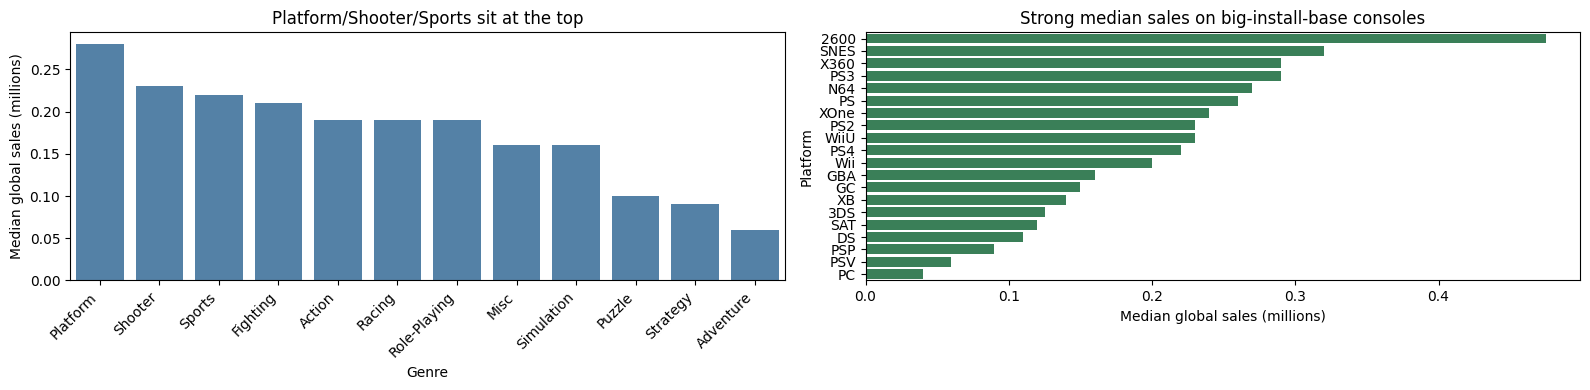

In [ ]:
# Which genres and platforms typically sell more? Use medians to soften the mega-hit effect.
genre_medians = sales_clean.groupby('Genre')['Global_Sales'].median().sort_values(ascending=False)
platform_medians = (sales_clean
    .groupby('Platform')
    .agg(median_sales=('Global_Sales','median'), count=('Name','size'))
    .query('count >= 100')  # keep platforms with real catalogs
    .sort_values('median_sales', ascending=False)
)
fig, axes = plt.subplots(1, 2, figsize=(16,4))
sns.barplot(x=genre_medians.index, y=genre_medians.values, color='steelblue', ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_ylabel('Median global sales (millions)')
axes[0].set_title('Platform/Shooter/Sports sit at the top')
sns.barplot(y=platform_medians.index, x=platform_medians['median_sales'], color='seagreen', ax=axes[1])
axes[1].set_xlabel('Median global sales (millions)')
axes[1].set_title('Strong median sales on big-install-base consoles')
plt.tight_layout()


/var/folders/ps/dp2pv5c94mgd208r06lxs13r0000gn/T/ipykernel_1947/17215465.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=publisher_totals.index, x=publisher_totals.values, palette='Blues_r')


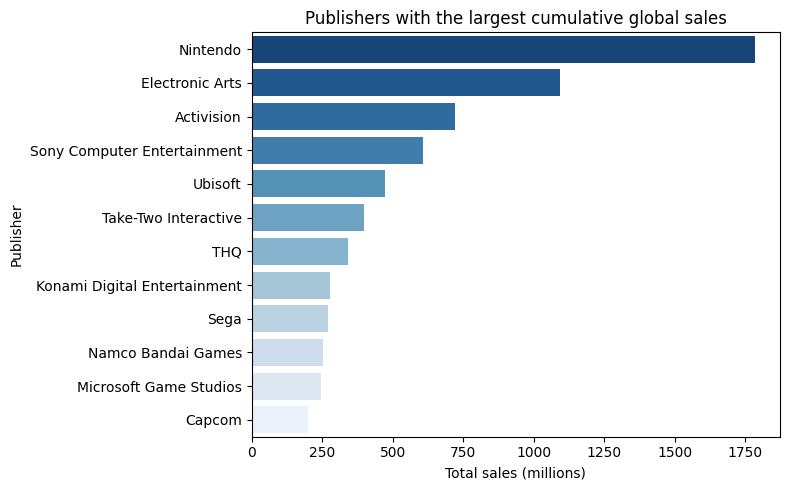

In [ ]:
# Who moves the most units in aggregate?
publisher_totals = sales_clean.groupby('Publisher')['Global_Sales'].sum().sort_values(ascending=False).head(12)
plt.figure(figsize=(8,5))
sns.barplot(y=publisher_totals.index, x=publisher_totals.values, palette='Blues_r')
plt.title('Publishers with the largest cumulative global sales')
plt.xlabel('Total sales (millions)')
plt.tight_layout()


/var/folders/ps/dp2pv5c94mgd208r06lxs13r0000gn/T/ipykernel_1947/2769122408.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=share_mean.index, y=share_mean.values, ax=axes[0], palette='muted')


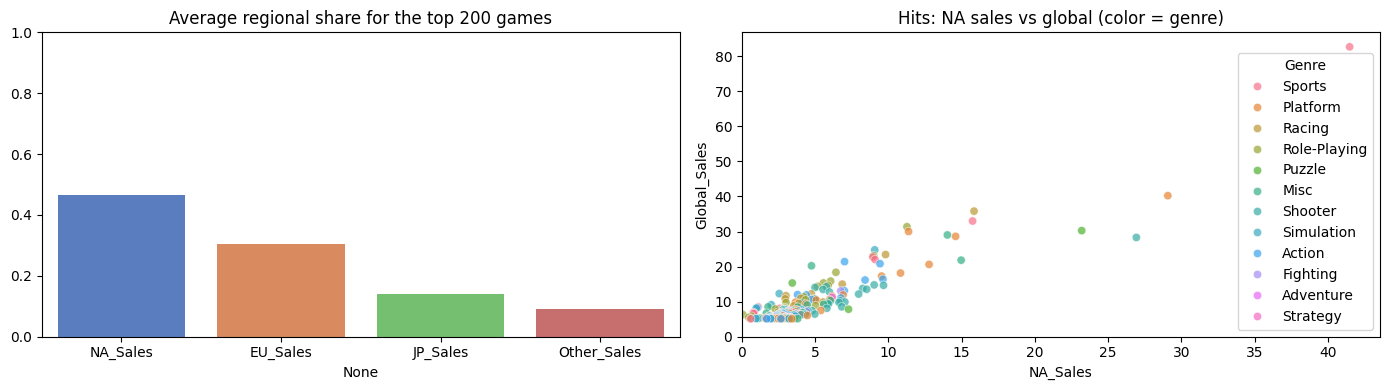

In [ ]:
# How do the biggest hits split by region?
top_hits = sales_clean.sort_values('Global_Sales', ascending=False).head(200)
region_cols = ['NA_Sales','EU_Sales','JP_Sales','Other_Sales']
region_share = top_hits[region_cols].div(top_hits['Global_Sales'], axis=0)
share_mean = region_share.mean().sort_values(ascending=False)
fig, axes = plt.subplots(1, 2, figsize=(14,4))
sns.barplot(x=share_mean.index, y=share_mean.values, ax=axes[0], palette='muted')
axes[0].set_ylim(0,1)
axes[0].set_title('Average regional share for the top 200 games')
sns.scatterplot(data=top_hits, x='NA_Sales', y='Global_Sales', hue='Genre', ax=axes[1], alpha=0.7)
axes[1].set_title('Hits: NA sales vs global (color = genre)')
axes[1].set_xlim(0, top_hits['NA_Sales'].max()*1.05)
axes[1].set_ylim(0, top_hits['Global_Sales'].max()*1.05)
plt.tight_layout()


### Key takeaways
- Sales are highly skewed; a small set of blockbusters dominates volume.
- Global totals (and per-title averages) peak around 2006–2011, then taper off.
  - This could be due to data incompleteness for more recent years, or a real trend.
- Platform, Shooter, and Sports games post the highest medians.
- Nintendo, EA, and Activision lead cumulative sales.
- For the biggest 200 games, NA and EU carry the bulk of global revenue; Japan is meaningful but smaller.
